# Imports / Config

In [1]:
from datetime import datetime
import os
import sys

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook

%matplotlib inline
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from content_corpus import ContentCorpus

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
%%time
recent_content_corpus = ContentCorpus(verbose=True)

CPU times: user 12 µs, sys: 1e+03 ns, total: 13 µs
Wall time: 17.9 µs


In [3]:
%%time
# recent_content_corpus.load_recent_content(df=pd.read_csv('recent_content_corpus.csv', index_col=0),
#                                           days_of_recent_content=3)
# recent_content_corpus.df['meta_keywords'] = recent_content_corpus.df['meta_keywords'].apply(lambda x: x if type(x)== type('this') else '')
recent_content_corpus.load_recent_content(days_of_recent_content=3)

CPU times: user 2min 16s, sys: 5.66 s, total: 2min 22s
Wall time: 3min 16s


In [4]:
recent_content_corpus.df.to_csv('recent_content_corpus.csv')

In [5]:
%%time
recent_content_corpus.vectorize_content()

CPU times: user 38.6 s, sys: 1.52 s, total: 40.2 s
Wall time: 40.3 s


In [6]:
%%time
recent_content_corpus.classify_content()


 svm classifier performance
 accuracy:   0.886
 classification report: 
                                precision    recall  f1-score   support

          Entertainment & Arts       0.90      0.86      0.88       217
            Finance & Business       0.83      0.87      0.85       435
            Lifestyle & Health       0.65      0.54      0.59        81
  Politics, Policy & Economics       0.90      0.89      0.90       318
                        Sports       0.96      0.99      0.97       834
Technology, Science & Medicine       0.77      0.74      0.75       243
                 Travel & Food       0.90      0.41      0.56        22

                   avg / total       0.88      0.89      0.88      2150

 confusion matrix: 
[[186   7   6   2   9   7   0]
 [  2 378   7  18   5  25   0]
 [  7   6  44   3   7  13   1]
 [  1  25   1 283   3   5   0]
 [  1   3   1   0 825   4   0]
 [  6  34   7   6  10 180   0]
 [  4   3   2   1   2   1   9]]


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:904: RuntimeWarning: divide by zero encountered in log
  return np.log(self.predict_proba(X))



 svm classifier performance
 accuracy:   0.877
 classification report: 
                      precision    recall  f1-score   support

          Asia & ANZ       0.88      0.96      0.92       493
              Europe       0.85      0.77      0.81       115
       Latin America       1.00      0.29      0.44         7
Middle East & Africa       1.00      0.81      0.90        85
       U.S. & Canada       0.83      0.79      0.81       187

         avg / total       0.88      0.88      0.87       887

 confusion matrix: 
[[471   2   0   0  20]
 [ 21  89   0   0   5]
 [  2   1   2   0   2]
 [  8   4   0  69   4]
 [ 31   9   0   0 147]]
CPU times: user 2 s, sys: 105 ms, total: 2.1 s
Wall time: 1.73 s


# TF-IDF Agglomerative Clustering

In [7]:
import numpy as np
from scipy.cluster.hierarchy import linkage as agglomerative_cluster
from tqdm import tqdm_notebook # NB: remove

import configs
from utils import clean, gen_clusters, lemmatize, simple_split, vectorize

## Story Clustering

In [8]:
topic = 'Politics, Policy & Economics'
regions = ['U.S. & Canada'] # World
MIN_WORDS = 100
filt = (
    (recent_content_corpus.df['topic_classification_predicted'] == topic)
    & (recent_content_corpus.df['region_classification_predicted'].apply(lambda x: x in regions))
    & (recent_content_corpus.df['text_word_count'] >= MIN_WORDS)
)
df_subset = recent_content_corpus.df[filt].reset_index().drop(['index'], axis=1)
n_articles = len(df_subset)
print(n_articles)

7230


In [9]:
df_subset = df_subset.sample(2000)
n_articles = len(df_subset)

In [10]:
%%time
docs = list(df_subset['text'].apply(clean).apply(lambda x: ' '.join(x.split(' ')[:MIN_WORDS])))

CPU times: user 194 ms, sys: 2.52 ms, total: 197 ms
Wall time: 195 ms


In [11]:
%%time
# replace w/ recent_content_corpus_objcect
doc_vectors_subset, idx_2_token = vectorize(docs, lemmatize_docs=False, max_synonym_merge_dist=0.1, tfidf=True)
doc_vectors_subset

CPU times: user 544 ms, sys: 8.37 ms, total: 553 ms
Wall time: 552 ms


In [12]:
%%time
docs_ac_result = agglomerative_cluster(
    doc_vectors_subset.toarray(),
    method='average',
    metric='euclidean',
    optimal_ordering=False
)

CPU times: user 15.4 s, sys: 146 ms, total: 15.6 s
Wall time: 15.7 s


In [13]:
docs_ac_result.shape

(1999, 4)

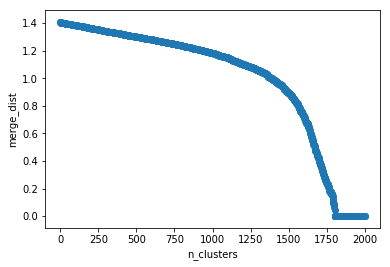

In [14]:
plt.scatter(np.arange(n_articles-1, 0, -1), docs_ac_result[:, 2])
plt.xlabel('n_clusters')
plt.ylabel('merge_dist')
# plt.ylim(0.6, 1.5)
plt.show()

In [15]:
rlng_n = 100
rlng_avg_dists = [np.mean(docs_ac_result[idx:idx+rlng_n, 2]) for idx in np.arange(n_articles-rlng_n)]

In [16]:
dists_slope = [rlng_avg_dists[idx+1] - rlng_avg_dists[idx] for idx in np.arange(len(rlng_avg_dists)-1)]

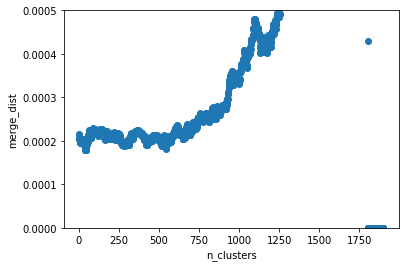

In [17]:
plt.scatter(np.arange(len(dists_slope), 0, -1), dists_slope)
plt.xlabel('n_clusters')
plt.ylabel('merge_dist')
# plt.xlim(0, 1000)
plt.ylim(0, 0.0005)
plt.show()
plt.close()

In [18]:
df_subset['story_cluster_id'] = gen_clusters(docs_ac_result, n_articles//10)

In [19]:
story_cluster_id_counts = df_subset['story_cluster_id'].value_counts()

In [20]:
story_cluster_id_counts

3791    181
3794    125
3782    124
3739    108
3774     78
3797     78
3786     57
3788     36
3795     35
3723     30
3687     29
3716     28
3653     28
3752     25
3673     24
3754     22
3759     21
3113     18
3736     18
3779     16
3768     15
3757     15
3641     15
3743     15
3661     14
3762     14
3773     14
3710     13
3511     13
3790     13
       ... 
3703      2
3606      2
3432      2
3715      2
3595      2
3590      2
3587      2
3584      2
3582      2
3570      2
3561      2
3540      2
3535      2
3529      2
3512      2
3499      2
3461      2
3440      2
3436      2
3669      2
724       1
305       1
1114      1
770       1
1870      1
1039      1
1071      1
1141      1
1197      1
1880      1
Name: story_cluster_id, Length: 200, dtype: int64

In [21]:
iterations = 0 
for idx, ct in zip(story_cluster_id_counts.index, story_cluster_id_counts.values):
    iterations += 1
    if iterations < 25:
        print('\n\n')
        print('%d articles in cluster %d' % (ct, idx))
        cluster_content = df_subset[
            df_subset['story_cluster_id'] == idx
        ]
        articles=len(cluster_content)
        for num, row in cluster_content[:min(20, articles)].iterrows():
            print('HEADLINE: '+row['title'])
#             print('Publisher: '+row['feed_url'])
#             print('SUMMARY: '+row['generated_summary'])
#             print('\n')




181 articles in cluster 3791
HEADLINE: Mark Meadows Counts Chief of Staff Position as ‘Incredible Honor’
HEADLINE: Mike Pence aide out of running to be Donald Trump's next chief of staff
HEADLINE: Schiff writes mock White House chief of staff job description
HEADLINE: Who's next? Here are 9 potential replacements for John Kelly
HEADLINE: Donald Trump's potential next chief of staff pick leaving White House
HEADLINE: John Kelly to leave White House by year-end: Trump
HEADLINE: Embattled Trump struggles to fill key White House post
HEADLINE: Trump Chooses Army General Mark Milley As His Top Military Advisor, Against Jim Mattis Wishes
HEADLINE: Trump says chief of staff John Kelly leaving at year’s end
HEADLINE: Trump chooses new Joint Chiefs of Staff chairman, against Mattis wishes
HEADLINE: Embattled Trump struggles to fill key White House post | Bangkok Post: news
HEADLINE: Trump still seeking chief of staff as Nick Ayers rules himself out of role
HEADLINE: 'There was no Plan B': Tr

In [ ]:
df_subset[
    df_subset['title'] == 'Jodie Marsh ends celibacy with her new man after nearly three years without sex'
].reset_index()['text'][0]

## Substory Clustering

In [41]:
story_filt = (df_subset['story_cluster_id'] == story_cluster_id_counts.index[1])
story_indices = np.where(story_filt)[0]
story_subset = df_subset[story_filt].reset_index().drop(['index'], axis=1)
story_doc_vectors_subset = doc_vectors_subset[story_indices, :]
story_n_articles = len(story_subset)

In [42]:
%%time
substory_ac_result = agglomerative_cluster(
    story_doc_vectors_subset.toarray(),
    method='average',
    metric='euclidean',
    optimal_ordering=False
)

CPU times: user 61.2 ms, sys: 7.81 ms, total: 69 ms
Wall time: 72.9 ms


In [43]:
substory_ac_result.shape

(124, 4)

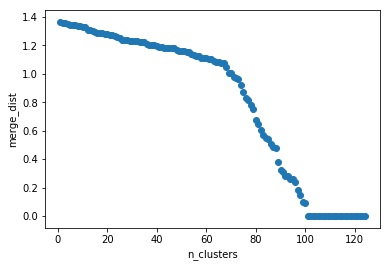

In [44]:
plt.scatter(np.arange(story_n_articles-1, 0, -1), substory_ac_result[:, 2])
plt.xlabel('n_clusters')
plt.ylabel('merge_dist')
plt.show()

In [45]:
rlng_n = 10
rlng_avg_dists = [np.mean(substory_ac_result[idx:idx+rlng_n, 2]) for idx in np.arange(story_n_articles-rlng_n)]

In [46]:
dists_slope = [rlng_avg_dists[idx+1] - rlng_avg_dists[idx] for idx in np.arange(len(rlng_avg_dists)-1)]

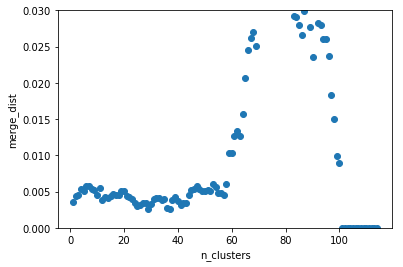

In [47]:
plt.scatter(np.arange(len(dists_slope), 0, -1), dists_slope)
plt.xlabel('n_clusters')
plt.ylabel('merge_dist')
# plt.xlim(0, 1000)
plt.ylim(0, 0.03)
plt.show()
plt.close()

In [48]:
story_subset['substory_cluster_id'] = gen_clusters(substory_ac_result, story_n_articles//10)

In [49]:
substory_cluster_id_counts = story_subset['substory_cluster_id'].value_counts()

In [50]:
iterations = 0 
for idx, ct in zip(substory_cluster_id_counts.index, substory_cluster_id_counts.values):
    iterations += 1
    if iterations < 25:
        print('\n\n')
        print('%d articles in cluster %d' % (ct, idx))
        cluster_content = story_subset[
            story_subset['substory_cluster_id'] == idx
        ]
        articles = len(cluster_content)
        for num, row in cluster_content[:min(20, articles)].iterrows():
            print('HEADLINE: '+row['title'])
#             print('SUMMARY: '+row['generated_summary'])
#             print('\n')




33 articles in cluster 234
HEADLINE: Top Democrats say Trump may face impeachment, jail over hush money
HEADLINE: Trump calls hush money payments a ‘simple private transaction’
HEADLINE: Top Democrats say Trump may face impeachment, jail over hush money
HEADLINE: Trump claims hush payments during 2016 campaign were legal
HEADLINE: Trump claims hush payments during 2016 campaign were legal
HEADLINE: Trump defends hush money payments as 'simple private transaction'
HEADLINE: Top Democrats say Trump may face impeachment, jail over hush money
HEADLINE: Top Democrats say Trump may face impeachment, jail over hush money
HEADLINE: Top Democrats say Trump may face impeachment, jail over hush money
HEADLINE: Trump defends hush money payments as 'simple private transaction'
HEADLINE: Trump blames lawyer Michael Cohen for hush money 'liability'
HEADLINE: Donald Trump: Michael Cohen Payoffs to Women a 'Private Transaction'
HEADLINE: President Trump defends payments to women as 'private transact

In [51]:
story_subset['substory_cluster_id'] = gen_clusters(substory_ac_result, story_n_articles//5)

In [52]:
substory_cluster_id_counts = story_subset['substory_cluster_id'].value_counts()

In [53]:
iterations = 0 
for idx, ct in zip(substory_cluster_id_counts.index, substory_cluster_id_counts.values):
    iterations += 1
    if iterations < 25:
        print('\n\n')
        print('%d articles in cluster %d' % (ct, idx))
        cluster_content = story_subset[
            story_subset['substory_cluster_id'] == idx
        ]
        articles = len(cluster_content)
        for num, row in cluster_content[:min(20, articles)].iterrows():
            print('HEADLINE: '+row['title'])
#             print('SUMMARY: '+row['generated_summary'])
#             print('\n')




20 articles in cluster 214
HEADLINE: Top Democrats say Trump may face impeachment, jail over hush money
HEADLINE: Trump calls hush money payments a ‘simple private transaction’
HEADLINE: Top Democrats say Trump may face impeachment, jail over hush money
HEADLINE: Trump defends hush money payments as 'simple private transaction'
HEADLINE: Top Democrats say Trump may face impeachment, jail over hush money
HEADLINE: Top Democrats say Trump may face impeachment, jail over hush money
HEADLINE: Top Democrats say Trump may face impeachment, jail over hush money
HEADLINE: Trump defends hush money payments as 'simple private transaction'
HEADLINE: Top Democrats say Trump may face impeachment over hush money
HEADLINE: Hush payments 'private transaction': Trump
HEADLINE: Top Democrats say Trump may face impeachment, jail over hush money
HEADLINE: Hush payments 'private transaction': Trump
HEADLINE: Top Democrats say Trump may face impeachment, jail over hush money
HEADLINE: Top Democrats say T

Winner: This